#### Human Protein Exploration

Using reference from this kernel https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/71039

In [1]:
import fastai
fastai.__version__

'1.0.28'

In [2]:
from fastai import *
from fastai.vision import *
from fastai.vision.image import *
import torch
import torch.nn as nn
import torchvision
import cv2
import scipy.optimize as opt

In [3]:
np.random.seed(42)

In [4]:
path = Path('data')

In [5]:
path.ls()

[PosixPath('data/first-submission.csv'),
 PosixPath('data/focal-loss-submission-384-unfreeze.csv'),
 PosixPath('data/focal_loss_gamma_0.25_512_unfreeze.csv'),
 PosixPath('data/unfreeze_resnet101_512_avg_preds_v1.csv'),
 PosixPath('data/threasholded_manual.csv'),
 PosixPath('data/threasholded.csv'),
 PosixPath('data/first-submission-384.csv'),
 PosixPath('data/train.csv'),
 PosixPath('data/resnet101_512_avg_preds.csv'),
 PosixPath('data/focal_loss_gamma_0.25_512_unfreeze-no-tta.csv'),
 PosixPath('data/train-0.csv'),
 PosixPath('data/focal-loss-submission-384-tmp.csv'),
 PosixPath('data/models'),
 PosixPath('data/resnet101_512.csv'),
 PosixPath('data/unfreeze_resnet152_386_avg_preds_v1.csv'),
 PosixPath('data/unfreeze_resnet152_386_preds_v1.csv'),
 PosixPath('data/test'),
 PosixPath('data/first-submission-512.csv'),
 PosixPath('data/.ipynb_checkpoints'),
 PosixPath('data/unfreeze_resnet101_512_avg_preds_v3.csv'),
 PosixPath('data/resnet101_386.csv'),
 PosixPath('data/unfreeze_resnet101_5

In [6]:
train_df = pd.read_csv(path / 'train.csv')

In [7]:
train_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [8]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [9]:
class Resnet4Channel(nn.Module):
    
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()
        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        w = encoder.conv1.weight
        
#         (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         (relu): ReLU(inplace)
#         (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w, torch.zeros(64, 1, 7, 7)), dim=1))
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth == 34 else 4), num_classes)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [10]:
def open_4_channel(fname):
    fname = str(fname)
    if fname.endswith(".png"):
        fname = fname[:-4]
        
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    
    img = [cv2.imread(fname + '_' + color + '.png', flags).astype(np.float32) / 255 for color in colors]
    
    x = np.stack(img, axis=-1)
    
    return Image(pil2tensor(x, np.float32).float())

In [11]:
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
      .random_split_by_pct(0.2)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [12]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [13]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [14]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [15]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [16]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [17]:
src.add_test(test_fnames, label='0');

In [18]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [19]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [20]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)

In [21]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=14).normalize(protein_stats))

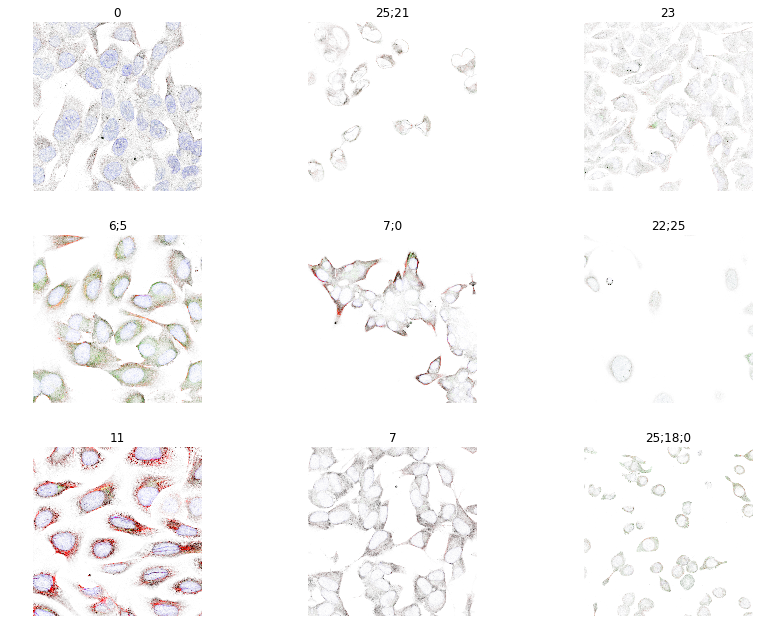

In [22]:
data.show_batch(rows=3, figsize=(12,9))

In [23]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [24]:
def resnet101(pretrained):
    return Resnet4Channel(encoder_depth=101)

In [25]:
def resnet152(pretrained):
    return Resnet4Channel(encoder_depth=152)

In [26]:
def _resnet_split(m): return (m[0][6],m[1])

In [27]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [28]:
learn = create_cnn(
    data,
    resnet152,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(6, 2e-2)

Total time: 28:24
epoch  train_loss  valid_loss  fbeta   
1      0.136706    0.154064    0.467205  (04:47)
2      0.133952    0.163898    0.439924  (04:42)
3      0.126768    0.134188    0.528912  (04:42)
4      0.119635    0.128615    0.575147  (04:38)
5      0.109096    0.105059    0.631425  (04:43)
6      0.105189    0.108723    0.647821  (04:51)



In [31]:
learn.save("freeze_224_resnet152")

In [32]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


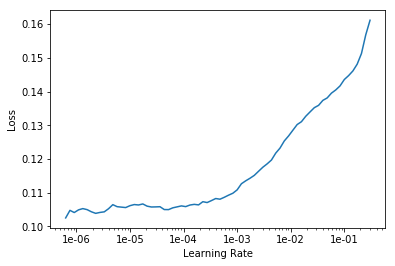

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(10, slice(1e-6, 1e-4))

Total time: 58:19
epoch  train_loss  valid_loss  fbeta   
1      0.104265    0.106359    0.648856  (05:50)
2      0.103181    0.106843    0.648336  (05:48)
3      0.104097    0.110716    0.649979  (05:46)
4      0.101267    0.111882    0.651823  (05:49)
5      0.101131    0.117760    0.656790  (05:50)
6      0.100462    0.110814    0.659326  (05:50)
7      0.098982    0.116079    0.661297  (05:50)
8      0.098494    0.115796    0.663006  (05:49)
9      0.099469    0.113735    0.662559  (05:50)
10     0.098276    0.111365    0.660896  (05:52)



In [35]:
learn.save("unfreeze_224_resnet152")

In [29]:
_ = learn.load("unfreeze_224_resnet152")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


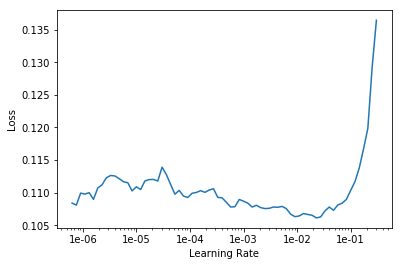

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(6, 3e-3)

epoch,train_loss,valid_loss,fbeta
1,0.100963,0.105555,0.685939
2,0.100337,0.098948,0.679998


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [32]:
learn.save("freeze_386_resnet152")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


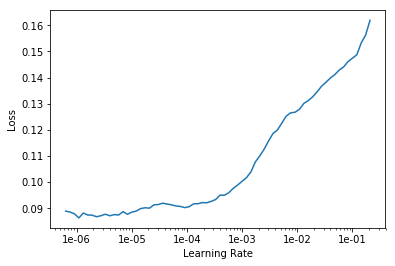

In [33]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(8, slice(1e-6, 5e-4))

Total time: 2:22:28
epoch  train_loss  valid_loss  fbeta   
1      0.091065    0.090219    0.704509  (17:51)
2      0.090173    0.089627    0.700719  (17:48)
3      0.095872    0.100438    0.694707  (17:49)
4      0.088782    0.115079    0.704204  (17:49)
5      0.087189    0.087575    0.707611  (17:51)
6      0.086255    0.147589    0.711559  (17:47)
7      0.086137    0.128039    0.721231  (17:45)
8      0.086316    0.129547    0.720230  (17:46)



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


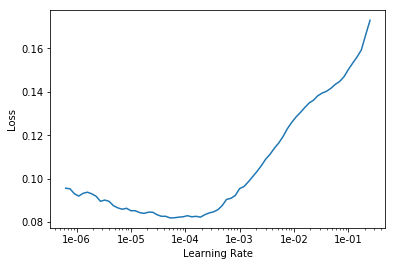

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(8, slice(1e-6, 5e-4))

Total time: 2:22:04
epoch  train_loss  valid_loss  fbeta   
1      0.080818    0.102341    0.716041  (17:43)
2      0.088870    0.114758    0.709813  (17:43)
3      0.086724    0.086039    0.709812  (17:44)
4      0.086751    0.102686    0.716246  (17:45)
5      0.085042    0.102775    0.722910  (17:46)
6      0.081432    0.085952    0.726522  (17:47)
7      0.080083    0.082270    0.730216  (17:47)
8      0.077398    0.254306    0.734158  (17:46)



In [38]:
learn.save("unfreeze_386_resnet152")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


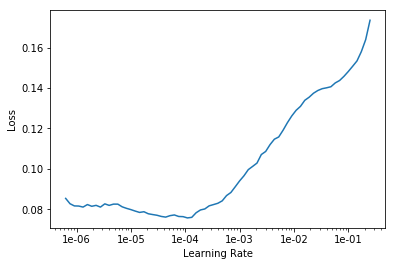

In [39]:
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(20, slice(1e-6, 5e-4))

Total time: 5:55:32
epoch  train_loss  valid_loss  fbeta   
1      0.077937    0.096427    0.727625  (17:44)
2      0.080794    0.151080    0.729345  (17:44)
3      0.077886    0.082477    0.732314  (17:45)
4      0.082263    0.116687    0.722028  (17:45)
5      0.079724    0.154304    0.713443  (17:45)
6      0.083956    0.101335    0.716100  (17:45)
7      0.083376    0.083032    0.715262  (17:47)
8      0.082907    0.096661    0.722937  (17:47)
9      0.080883    0.092418    0.726455  (17:46)
10     0.078694    0.092354    0.728678  (17:47)
11     0.077686    0.087212    0.737275  (17:47)
12     0.076829    0.080280    0.737453  (17:46)
13     0.073919    0.088253    0.738890  (17:47)
14     0.073442    0.242168    0.737389  (17:47)
15     0.071334    0.083323    0.739135  (17:47)
16     0.071824    0.078019    0.750077  (17:47)
17     0.071077    0.079581    0.748067  (17:47)
18     0.068032    0.079857    0.748723  (17:47)
19     0.067842    0.078606    0.745346  (17:48)
20     0.

In [41]:
learn.save("unfreeze_386_resnet152")

In [29]:
_ = learn.load("unfreeze_386_resnet152")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


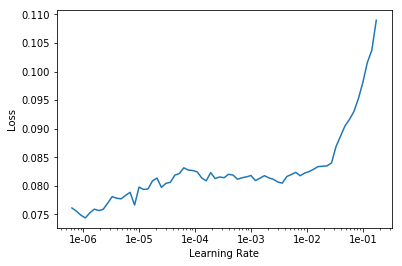

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
learn.fit_one_cycle(8, 3e-3)

Total time: 2:40:14
epoch  train_loss  valid_loss  fbeta   
1      0.080291    0.089569    0.737146  (20:03)
2      0.086036    0.124826    0.710115  (20:00)
3      0.087503    0.091414    0.703448  (20:01)
4      0.089633    0.311940    0.701744  (20:01)
5      0.083265    0.225460    0.734231  (20:01)
6      0.076562    0.250655    0.742256  (20:01)
7      0.077707    0.078134    0.740304  (20:01)
8      0.074130    0.105708    0.746295  (20:02)



In [ ]:
learn.save("freeze_512_resnet152")

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,fbeta
1,0.074416,0.078757,0.747703
2,0.070150,0.143844,0.747570
3,0.073871,0.086088,0.746699
4,0.073300,0.080422,0.750347


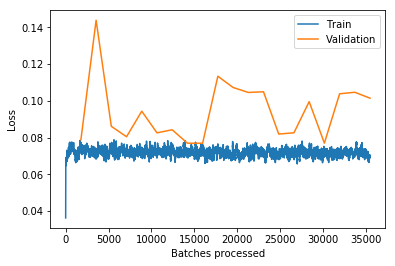

In [33]:
learn.recorderder.plot_losses()

In [34]:
learn.save("freeze_512_resnet152")

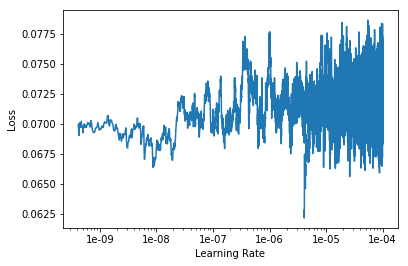

In [35]:
learn.recorder.plot()

In [41]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

Total time: 40:22



In [42]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'unfreeze_resnet152_512_avg_pred_v1.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 25


In [43]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'unfreeze_resnet152_512_preds_v1.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5 25
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 25


##### TTA scores

In [33]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

Total time: 40:36



In [34]:
preds.shape

torch.Size([11702, 28])

In [35]:
avg_pred.shape

torch.Size([11702, 28])

In [36]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(avg_pred)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101_512_avg_preds.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 25


In [41]:
beta = 0.4
final_preds = preds*beta + avg_pred*(1-beta)

In [42]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > 0.2)[0]])) for row in np.array(final_preds)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101_512_final_preds.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 25


In [43]:
#### avg_preds performed much better!

##### Threasholding

In [44]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds, avg_pred, y = learn.TTA(beta=None, scale=1.05)

Total time: 22:01



In [45]:
preds_, avg_pred_, y_ = preds.numpy(), avg_pred.numpy(), y.numpy()

In [59]:
# F1 score based on Kaggle Kernel
def F1_soft(preds, targs, th=0.5, d=50.0):
    preds = sigmoid_np( d * (preds - th))
    targs = targs.astype(np.float)

    score = 2.0 * (preds * targs).sum(axis=1) / ((preds + targs).sum(axis=1) + 1e-9)
    return score

# F1 score based on Fastai matrix
def fbeta2(y_pred, y_true, thresh=0.2, beta=1, eps=1e-9, sigmoid=False):
    beta2 = beta**2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean()

def fit_val(x,y):
    params = 0.5 * np.ones(28)
    wd = 1e-5
    error = lambda p: np.concatenate((F1_soft(x, y, p) - 1.0, wd * (p - 0.5)), axis=None)
    p, success = opt.leastsq(error, params)
    return p

In [63]:
th = fit_val(avg_pred_, y_)
th[th < 0.1] = 0.1
print('Thresholds: ', th)

th_gpu = th.copy()
th_gpu = torch.FloatTensor(th_gpu)

print('F1 macro: ', fbeta2(avg_pred, y, th_gpu))
print('F1 macro (th = 0.2): ', fbeta2(avg_pred, y, 0.2))
print('F1 macro (th = 0.5): ', fbeta2(avg_pred, y, 0.5))

print('F1 macro: ', fbeta2(preds, y, th_gpu))
print('F1 macro (th = 0.2): ', fbeta2(preds, y, 0.2))
print('F1 macro (th = 0.5): ', fbeta2(preds, y, 0.5))

Thresholds:  [0.219664 0.167961 0.257473 0.199919 0.22539  0.186263 0.168383 0.193929 0.221295 0.181471 0.314688 0.164075 0.183212
 0.236929 0.15789  8.697891 0.449306 0.479556 0.227879 0.156333 0.408823 0.15917  0.218963 0.145534 0.438345 0.200315
 0.355311 0.304825]
F1 macro:  tensor(0.7679)
F1 macro (th = 0.2):  tensor(0.7672)
F1 macro (th = 0.5):  tensor(0.7318)
F1 macro:  tensor(0.7606)
F1 macro (th = 0.2):  tensor(0.7598)
F1 macro (th = 0.5):  tensor(0.7325)


In [64]:
def sigmoid_np(x):
    return 1.0/(1.0 + np.exp(-x))

preds_test, avg_pred_test, y_test = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

Total time: 41:02



In [65]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row > th)[0]])) for row in np.array(avg_pred_test)]
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'resnet101_512_avg_preds_threshold.csv', header=True, index=False)
df.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,0 7 23 25


In [ ]:
# def calc_threshold(pred):
#     threshold_dict = dict()
#     for idx in tqdm(range(28)):
#         m = 0
#         for ii in range(100):
#             threshold0 = ii * 0.01
#             f1_val = f1_score(y_cat_train_dic[idx], threshold0 < (pred[:,idx]))
#             if m < f1_val:
#                 threshold_dic[idx] = threshold0+0.005
#                 m = f1_val
#     return threshold_dic